In [1]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_utils import *
import sys
from tqdm.notebook import tqdm

# Add the path to the online_bptt module
sys.path.append('../')

from online_bptt.model.network import RNN
from online_bptt.model_factory import parameter_conversion_normal_to_forward
from online_bptt.model.cells import LRUCell

dtype = jnp.float64
# Run tests on CPU to avoid GPU OOM/solver issues in CI
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

cmap = matplotlib.cm.RdPu

In [2]:
def ravel_pytree(pytree):
    leaves, _ = jax.tree_util.tree_flatten(pytree)
    flat_array = jnp.concatenate([jnp.ravel(leaf) for leaf in leaves])
    return flat_array

def tree_cosine_similarity(a, b):
    a_flat = ravel_pytree(a)
    b_flat = ravel_pytree(b)
    return jnp.dot(a_flat, b_flat) / (jnp.linalg.norm(a_flat) * jnp.linalg.norm(b_flat) + 1e-8)

In [3]:
def mse_loss(pred, target, mask):
    return jnp.mean(mask * (pred - target) ** 2)


full_loss = lambda x, y, m: jax.vmap(mse_loss)(x, y, m).sum()

def get_gradient_similarities(key, seq_len, lru_r_min, base_precision=dtype, increased_precision=dtype):
    input_dim = 32
    hidden_dim = 32
    output_dim = 32

    key, subkey = random.split(key)
    inputs = random.normal(subkey, (seq_len, input_dim), dtype=dtype)
    targets = jnp.zeros((seq_len, output_dim), dtype=dtype)
    masks = jnp.ones((seq_len,), dtype=dtype)

    cell_func = partial(LRUCell, r_min=lru_r_min)
    
    rnn_func = partial(
        RNN,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        increased_precision=increased_precision,
        base_precision=base_precision,
        cell_type=cell_func,
    )
    forward_bptt_rnn = rnn_func(training_mode="forward_forward")
    standard_rnn = rnn_func(training_mode="normal")

    key, subkey = random.split(key)
    standard_params = standard_rnn.init(subkey, inputs)
    params = forward_bptt_rnn.init(subkey, inputs)
    params = parameter_conversion_normal_to_forward(standard_params, params)

    def loss_fn_params(p, x, y, m, model):
        y_hat = model.apply(p, x)
        return full_loss(y_hat, y, m)

    grad_bptt_params, grad_bptt_inputs = jax.grad(loss_fn_params, argnums=(0, 1))(standard_params, inputs, targets, masks, standard_rnn)
    grad_ff_params, grad_ff_inputs = jax.grad(loss_fn_params, argnums=(0, 1))(params, inputs, targets, masks, forward_bptt_rnn)
    
    # The forward-forward gradients are for the converted parameters, so we need to select the correct part
    grad_ff_params_comparable = grad_ff_params['params']['ForwardBPTTLayer_0']['layer']['cell']

    param_sim = tree_cosine_similarity(grad_ff_params_comparable, grad_bptt_params['params']['StandardLayer_0']['layer'])
    input_sim = tree_cosine_similarity(grad_ff_inputs, grad_bptt_inputs)
    
    return param_sim, input_sim

In [4]:
# --- Experiment setup ---
lru_r_mins = [0.36, 0.68, 0.84, 0.92, 0.96, 0.98, 0.99]
seq_lens = [30, 100, 300, 1000]
n_seeds = 10 # takes 1 minute per seed roughly

results = []
key = random.PRNGKey(0)

for i, seq_len in enumerate(seq_lens):
    print(i, seq_len)
    for r_min in lru_r_mins:
        param_sims = []
        input_sims = []
        for seed in range(n_seeds):
            key, subkey = random.split(key)
            param_sim, input_sim = get_gradient_similarities(subkey, seq_len, r_min)
            param_sims.append(param_sim)
            input_sims.append(input_sim)
        
        results.append({
            "seq_len": seq_len,
            "lru_r_min": r_min,
            "param_sim_mean": jnp.mean(jnp.array(param_sims)),
            "param_sim_std": jnp.std(jnp.array(param_sims)),
            "input_sim_mean": jnp.mean(jnp.array(input_sims)),
            "input_sim_std": jnp.std(jnp.array(input_sims)),
        })

df = pd.DataFrame(results)

0 30
1 100
1 100
2 300
2 300
3 1000
3 1000


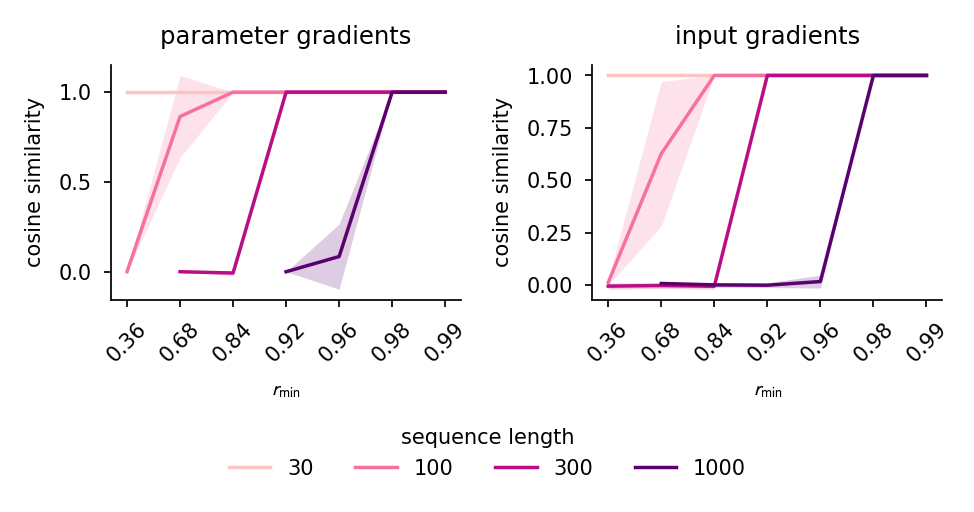

In [5]:
import numpy as np
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

r_min_labels = sorted(df['lru_r_min'].unique())
x_indices = np.arange(len(r_min_labels))

for i, seq_len in enumerate(seq_lens):
    subset = df[df['seq_len'] == seq_len].sort_values('lru_r_min')
    color = cmap(0.25 + 0.7 * i / (len(seq_lens) - 1))
    
    # Plot for parameter gradients
    mean = np.array(subset['param_sim_mean'].tolist())
    std = np.array(subset['param_sim_std'].tolist())
    axes[0].plot(x_indices, mean, label=seq_len, c=color)
    axes[0].fill_between(x_indices, mean - std, mean + std, color=color, alpha=0.2, lw=0)
    
    # Plot for input gradients
    mean = np.array(subset['input_sim_mean'].tolist())
    std = np.array(subset['input_sim_std'].tolist())
    axes[1].plot(x_indices, mean, label=seq_len, c=color)
    axes[1].fill_between(x_indices, mean - std, mean + std, color=color, alpha=0.2, lw=0)

for ax in axes:
    ax.set_xlabel(r'$r_\min$')
    ax.set_xticks(x_indices)
    ax.set_xticklabels(r_min_labels, rotation=45)
    ax.set_ylabel('cosine similarity')

axes[0].set_title('parameter gradients', size=7)
axes[1].set_title('input gradients', size=7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(seq_lens), title="sequence length", frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('plots/gradient_alignment_sequence_length.pdf')
plt.show()

In [6]:
# --- Experiment setup ---
lru_r_mins = [0.36, 0.68, 0.84, 0.92, 0.96, 0.98, 0.99]
dtypes = [(jnp.float32, jnp.float32), (jnp.float32, jnp.float64), (jnp.float64, jnp.float64)]
n_seeds = 10 # takes 1 minute per seed roughly
seq_len = 100

results = []
key = random.PRNGKey(0)

for i, dt in enumerate(dtypes):
    print(i, dt)
    for r_min in lru_r_mins:
        param_sims = []
        input_sims = []
        for seed in range(n_seeds):
            key, subkey = random.split(key)
            bdt, idt = dt
            param_sim, input_sim = get_gradient_similarities(subkey, seq_len, r_min, base_precision=bdt, increased_precision=idt)
            param_sims.append(param_sim)
            input_sims.append(input_sim)
        
        results.append({
            "dtype": dt,
            "lru_r_min": r_min,
            "param_sim_mean": jnp.mean(jnp.array(param_sims)),
            "param_sim_std": jnp.std(jnp.array(param_sims)),
            "input_sim_mean": jnp.mean(jnp.array(input_sims)),
            "input_sim_std": jnp.std(jnp.array(input_sims)),
        })

df_dtype = pd.DataFrame(results)

0 (<class 'jax.numpy.float32'>, <class 'jax.numpy.float32'>)


1 (<class 'jax.numpy.float32'>, <class 'jax.numpy.float64'>)
1 (<class 'jax.numpy.float32'>, <class 'jax.numpy.float64'>)
2 (<class 'jax.numpy.float64'>, <class 'jax.numpy.float64'>)
2 (<class 'jax.numpy.float64'>, <class 'jax.numpy.float64'>)


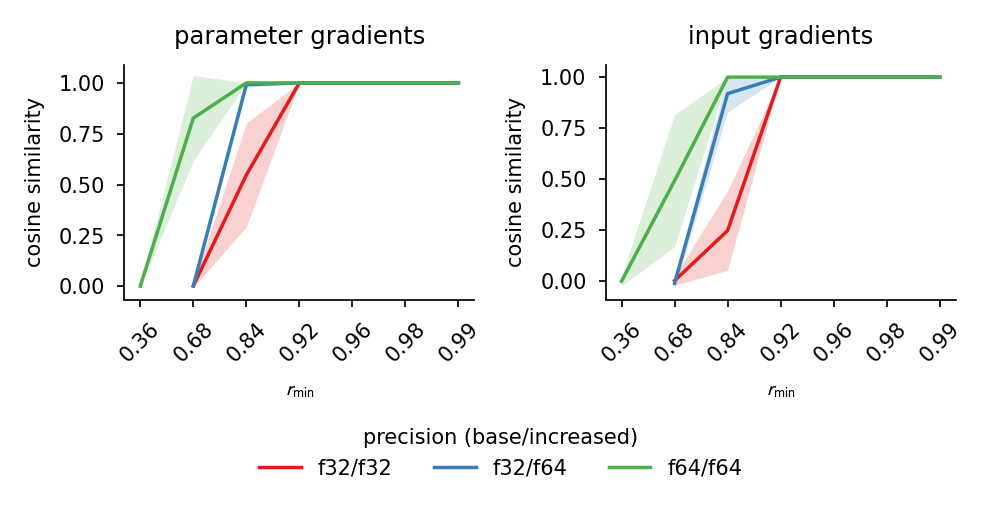

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

r_min_labels = sorted(df_dtype['lru_r_min'].unique())
x_indices = np.arange(len(r_min_labels))

dtype_labels = {
    (jnp.float32, jnp.float32): "f32/f32",
    (jnp.float32, jnp.float64): "f32/f64",
    (jnp.float64, jnp.float64): "f64/f64",
}

for i, dt in enumerate(dtypes):
    # The following line was causing an error because the dtype column contains tuples, 
    # which are not directly comparable. We need to convert them to strings or handle them differently.
    # For now, let's filter manually.
    
    current_df = df_dtype[df_dtype['dtype'].apply(lambda x: str(x) == str(dt))].sort_values('lru_r_min')

    color = plt.cm.Set1(i)
    
    # Plot for parameter gradients
    mean = np.array(current_df['param_sim_mean'].tolist())
    std = np.array(current_df['param_sim_std'].tolist())
    axes[0].plot(x_indices, mean, label=dtype_labels[dt], c=color)
    axes[0].fill_between(x_indices, mean - std, mean + std, color=color, alpha=0.2, lw=0)
    
    # Plot for input gradients
    mean = np.array(current_df['input_sim_mean'].tolist())
    std = np.array(current_df['input_sim_std'].tolist())
    axes[1].plot(x_indices, mean, label=dtype_labels[dt], c=color)
    axes[1].fill_between(x_indices, mean - std, mean + std, color=color, alpha=0.2, lw=0)

for ax in axes:
    ax.set_xlabel(r'$r_\min$')
    ax.set_xticks(x_indices)
    ax.set_xticklabels(r_min_labels, rotation=45)
    ax.set_ylabel('cosine similarity')

axes[0].set_title('parameter gradients', size=7)
axes[1].set_title('input gradients', size=7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(dtypes), title="precision (base/increased)", frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('plots/gradient_alignment_precision.pdf')
plt.show()